In [1]:
!pip install transformers[torch] -q
!pip install umap-learn numpy matplotlib -q

In [2]:
import warnings
# To ignore all warnings (not recommended unless you're sure about the consequences)
warnings.filterwarnings("ignore")

In [3]:
import torch
import pandas as pd
import numpy as np
import os
from transformers import AutoTokenizer,AutoModelForMaskedLM
from transformers import pipeline

In [4]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import re
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import plotly.express as px

In [5]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [6]:
model1=AutoModelForMaskedLM.from_pretrained('sampathlonka/San-BERT') 
model1

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [7]:
tokenizer1=AutoTokenizer.from_pretrained('sampathlonka/San-BERT')
tokenizer1

BertTokenizerFast(name_or_path='sampathlonka/San-BERT', vocab_size=30522, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [8]:
data = pd.read_excel('/kaggle/input/raghuvamsa-sarga-3-sentiments/raghuvamsha_sarga_03.xlsx')  # Replace 'your_excel_file.xlsx' with your file path

In [9]:
data.SanskritText[7]

'\n\nनिधानगर्भामिव सागराम्बरां शमीमिवाभ्यन्तरलीनपावकाम्|\nनदीमिवान्तःसलिलां सरस्वतीं नृपः ससत्त्वां महिषीममन्यत॥ ३-९'

In [10]:
data['SanskritText'] = data['SanskritText'].apply(lambda text: re.sub(r'\n', '', str(text)))
data['SanskritText'] = data['SanskritText'].apply(lambda text: re.sub(r'|', '', str(text)))
data['SanskritText'] = data['SanskritText'].apply(lambda text: re.sub(r'॥', '', str(text)))
data['SanskritText'] = data['SanskritText'].apply(lambda text: re.sub(r'३', '', str(text)))
data['SanskritText'] = data['SanskritText'].apply(lambda text: re.sub(r'१', '', str(text)))
data['SanskritText'] = data['SanskritText'].apply(lambda text: re.sub(r'२', '', str(text)))
data['SanskritText'] = data['SanskritText'].apply(lambda text: re.sub(r'४', '', str(text)))
data['SanskritText'] = data['SanskritText'].apply(lambda text: re.sub(r'५', '', str(text)))
data['SanskritText'] = data['SanskritText'].apply(lambda text: re.sub(r'६', '', str(text)))
data['SanskritText'] = data['SanskritText'].apply(lambda text: re.sub(r'७', '', str(text)))
data['SanskritText'] = data['SanskritText'].apply(lambda text: re.sub(r'९', '', str(text)))
data['SanskritText'] = data['SanskritText'].apply(lambda text: re.sub(r'०', '', str(text)))
data['SanskritText'] = data['SanskritText'].apply(lambda text: re.sub(r'८', '', str(text)))
data['SanskritText'] = data['SanskritText'].apply(lambda text: re.sub(r'-', '', str(text)))

In [11]:
embedding=[]

In [12]:
for i in range(len(data)):
    with torch.no_grad():
        t = tokenizer1.encode(data.SanskritText[i][0],max_length=512, padding=True, truncation=True, return_tensors="pt")
        model_output = model1.bert(t).last_hidden_state
        model_output = model_output.squeeze()
        out = torch.mean(model_output,dim=0)
        out_numpy = out.numpy()
        embedding.append(out_numpy)

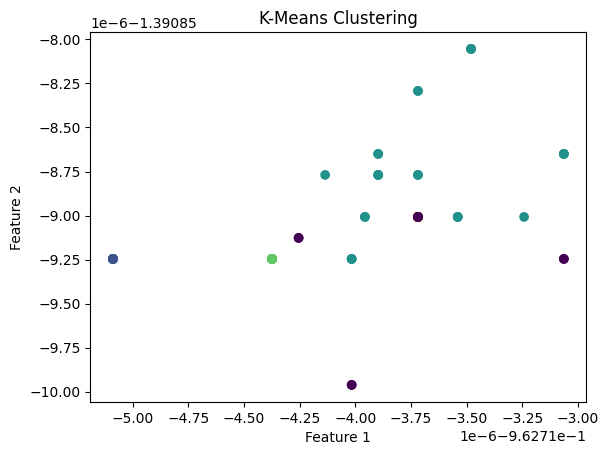

Cluster 0 - Number of samples: 16
0     अथेप्सितं भर्तुरुपस्थितोदयं सखीजनोद्वीक्षणकौमु...
13    अरिष्टशय्यां परितो विसारिणा सुजन्मनस्तस्य निजे...
25    अमंस्त चानेन परार्ध्यजन्मना स्थितेरभेत्ता स्थि...
27    अथोपनीतं विधिवद्विपश्चितो विनिन्युरेनं गुरवो ग...
30    महोक्षतां वत्सतरः स्पृशन्निव द्विपेन्द्रभावं क...
Name: SanskritText, dtype: object
Cluster 1 - Number of samples: 6
4     न मे ह्रिया शंसति किंचिदीप्सितं स्पृहावती वस्त...
7     निधानगर्भामिव सागराम्बरां शमीमिवाभ्यन्तरलीनपाव...
15    निवातपद्मस्तिमितेन चक्षुषा नृपस्य कान्तं पिबतः...
18    न संयतस्तस्य बभूव रक्षितुर्विसर्जयेद्यं सुतजन्...
34    नरेन्द्रमूलायतनादनन्तरं तदास्पदं श्रीर्युवराजस...
Name: SanskritText, dtype: object
Cluster 2 - Number of samples: 25
1    शरीरसादादसमग्रभूषणा मुखेन सालक्ष्यत लोध्रपाण्ड...
3    दिवं मरुत्वानिव भोक्ष्यते भुवं दिगन्तविश्रान्त...
5    उपेत्य सा दोहददुःखशीलतां यदेव वव्रे तदपश्यदाहृ...
6    क्रमेण निस्तीर्य च दोहदव्यथां प्रचीयमानावयवा र...
8    प्रियानुरागस्य मनः समुन्नतेर्भुजार्जितानां च द

In [13]:
X = np.array(embedding)

# Step 5: Perform K-Means clustering
num_clusters = 5  # You can change the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X)

# Step 6: Visualize the clusters (you can customize this part based on your needs)
# For example, you can create a scatter plot of the clusters
plt.scatter(X[:, 0], X[:, 1], c=cluster_labels, cmap='viridis')
plt.title('K-Means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Step 7: Analyze the clusters and their contents
# You can explore the contents of each cluster to see the similarities among them.
clustered_data = data.copy()
clustered_data['Cluster'] = cluster_labels
for cluster_id in range(num_clusters):
    cluster_contents = clustered_data[clustered_data['Cluster'] == cluster_id]
    print(f"Cluster {cluster_id} - Number of samples: {len(cluster_contents)}")
    print(cluster_contents['SanskritText'].head())  # Display some text samples in the cluster

In [14]:
X = np.array(embedding)

# Step 5: Perform K-Means clustering
num_clusters = 5  # You can change the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X)

# Create a DataFrame with cluster labels and sentiments
clustered_data = data.copy()
clustered_data['Cluster'] = cluster_labels
clustered_data['Sentiment'] = data['Sentiment']

# Step 6: Create an interactive scatter plot using Plotly
fig = px.scatter(
    clustered_data,
    x=X[:, 0],
    y=X[:, 1],
    color='Cluster',
    hover_name='Sentiment',  # This will show Sentiment when hovering
    title='K-Means Clustering with Sentiment Labels',
    labels={'Cluster': 'Cluster'},
)

fig.show()

In [15]:
X = np.array(embedding)

y = data['Sentiment'].values

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
missing_values = data.isnull().sum()

In [18]:
missing_values

SanskritText    0
Sentiment       0
dtype: int64

In [19]:
svc = SVC(kernel='linear', C=1.0)
svc.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svc.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.00


In [20]:
X = np.array(embedding)

# Prepare the target labels (Sentiment) as a numpy array
y = data['Sentiment'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.00


In [21]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (55, 768)
X_test shape: (14, 768)
y_train shape: (55,)
y_test shape: (14,)
